# Beers in the USA: a prediction of State of origin based on beer tastes

## imports

In [1]:
from src.data.save_tar_gz import tar_gz_to_csv
from src.utils.data_utils import *
from src.data.breweries import *
from src.data.load_data import get_beer_merged, load_breweries, merge_ratings_breweries, get_states_from_df
from src.utils.data_utils import merge_breweries, merge_reviews
import src.data.loader as loader

import warnings
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import src.data.wrangling as wrangling
from datetime import datetime

from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from src.data.distances import compute_distances
from src.data.distances import load_distances
from src.data.breweries import *




## Loading the data into dict. of dataframes

This part loads the data from the specified path from the .tar.gz files and saves them as .csv. Already existing .csv will be loaded but not created. clean_load can be set to True to clean all existing .csv and creating them.

In [13]:
data = data_loader.load('data/raw/', 'data/clean', clean_load=True)
wrangling.clean_data('data/clean', clean_load=False)

In [2]:
ba_usa_ratings = get_beer_merged('data/clean/BeerAdvocate')
rb_usa_ratings = get_beer_merged('data/clean/RateBeer')
matched_usa_ratings = pd.read_csv("data/clean/MatchedBeerData/ratings.csv")
breweries_ba = load_breweries('data/clean/BeerAdvocate')
breweries_rb = load_breweries('data/clean/RateBeer')
breweries_matched = load_breweries('data/clean/MatchedBeerData')

usa_ratings = merge_reviews(ba_usa_ratings, rb_usa_ratings, matched_usa_ratings)
breweries = merge_breweries(breweries_ba, breweries_rb, breweries_matched)

# Partie Locality of Beer consumption un peu cleaned up + la matrice

## Locality of Beer consumption

For each state we look at the proportion of reviews that are made on local beers (from the same state), national beers (beers from other states) or foreign beers.

In [3]:
#usa_ratings_merged = loader.merge_ratings_breweries(usa_ratings, breweries)
usa_ratings_merged = merge_ratings_breweries(usa_ratings, breweries)
#states = loader.get_states_from_df(usa_ratings_merged)
states = get_states_from_df(usa_ratings_merged)

#### Top 12 states with the highest local reviews ratio 

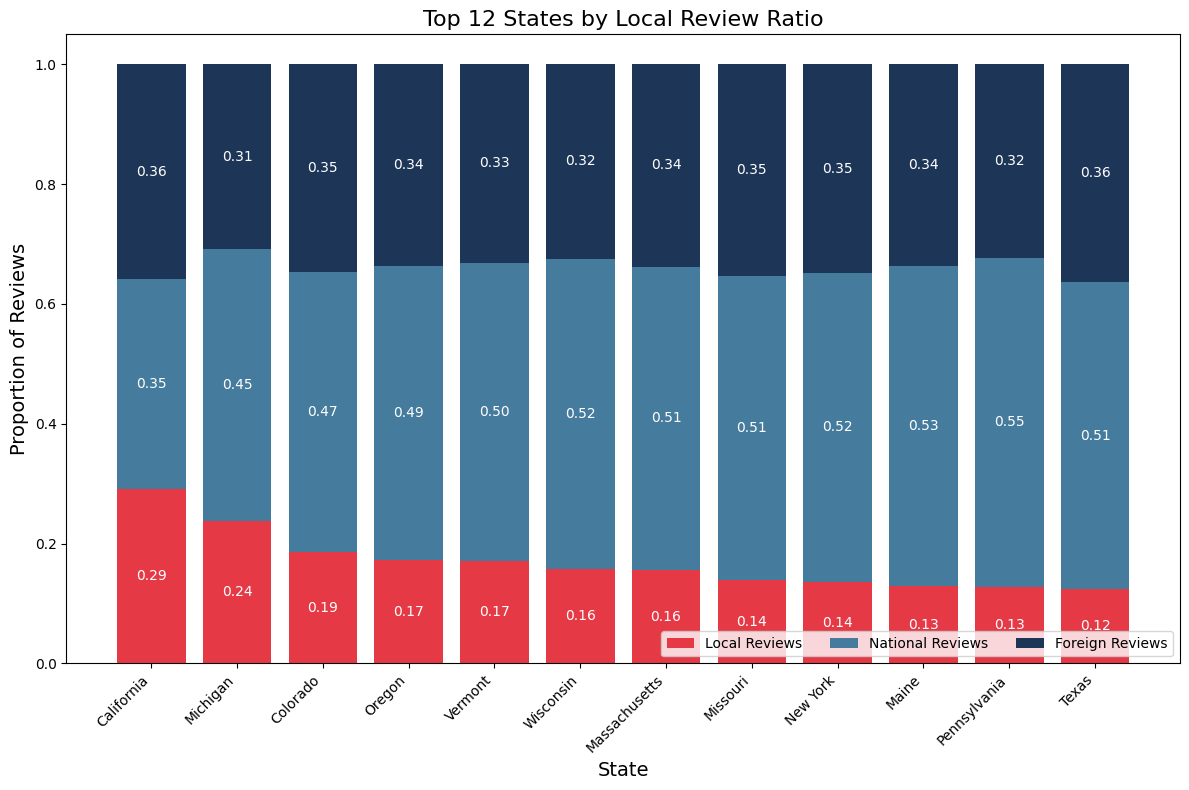

In [5]:
from src.data.plots import plot_provenance

# Plot the top 12 states with the highest local reviews ratio

us_colors = {
    "local_count": "#e63946",
    "national_count": "#457b9d",
    "foreign_count": "#1d3557"
}

top_n_states = 12

fig, ax = plot_provenance(usa_ratings_merged, states, top_k=top_n_states, sort_option="local_count", 
                          ascending=False, width=0.8, as_ratio=True, colors=us_colors)

ax.set_title(f'Top {top_n_states} States by Local Review Ratio', fontsize=16)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Proportion of Reviews', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Top 12 states with the highest review count

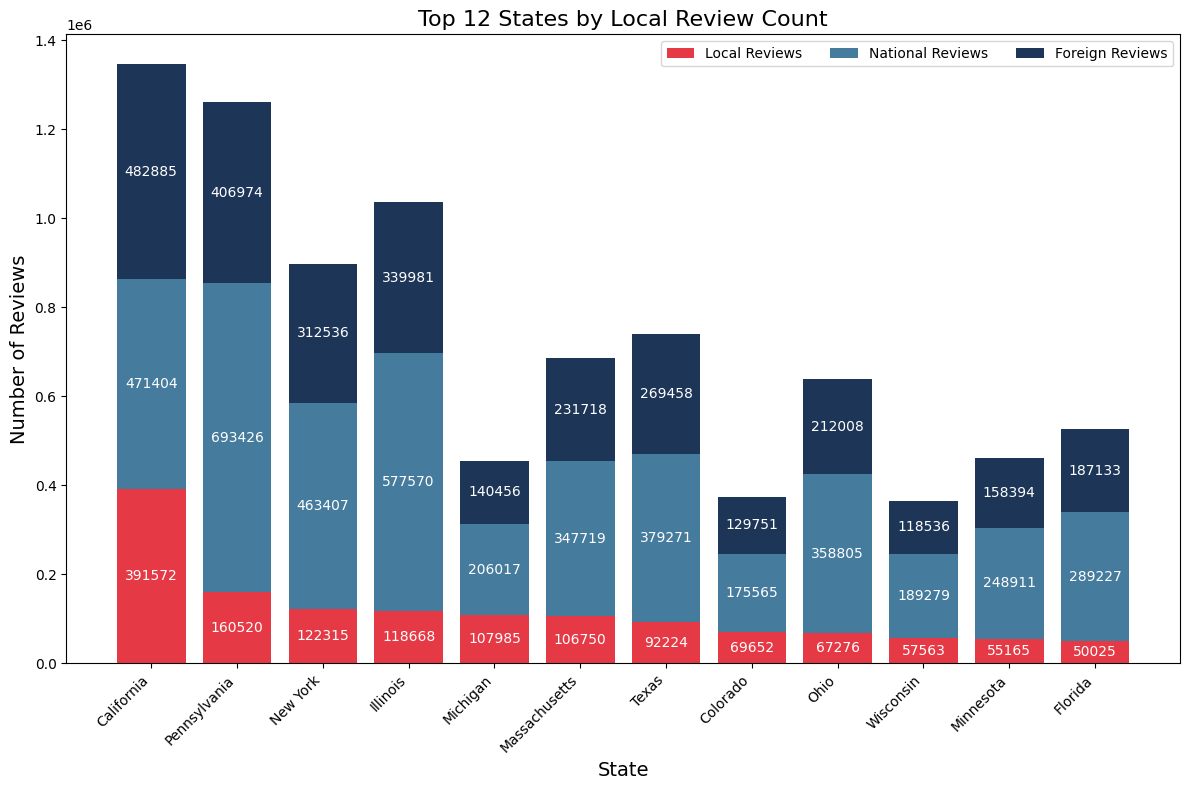

In [6]:
top_n_states = 12

fig, ax = plot_provenance(usa_ratings_merged, states, top_k=top_n_states, sort_option="local_count", 
                          ascending=False, width=0.8, as_ratio=False, colors=us_colors)

ax.set_title(f'Top {top_n_states} States by Local Review Count', fontsize=16)
ax.set_xlabel('State', fontsize=14)
ax.set_ylabel('Number of Reviews', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### State wise reviews visualized as an adjacency matrix

For each state we compute the number of reviews from the state to another state. This gives a 50x50 adjacency matrix. We decided to plot it as a heatmap to see if any intersting patterns would arise. For each state we look at the ratio and not the total count as otherwise most of the plot would be black

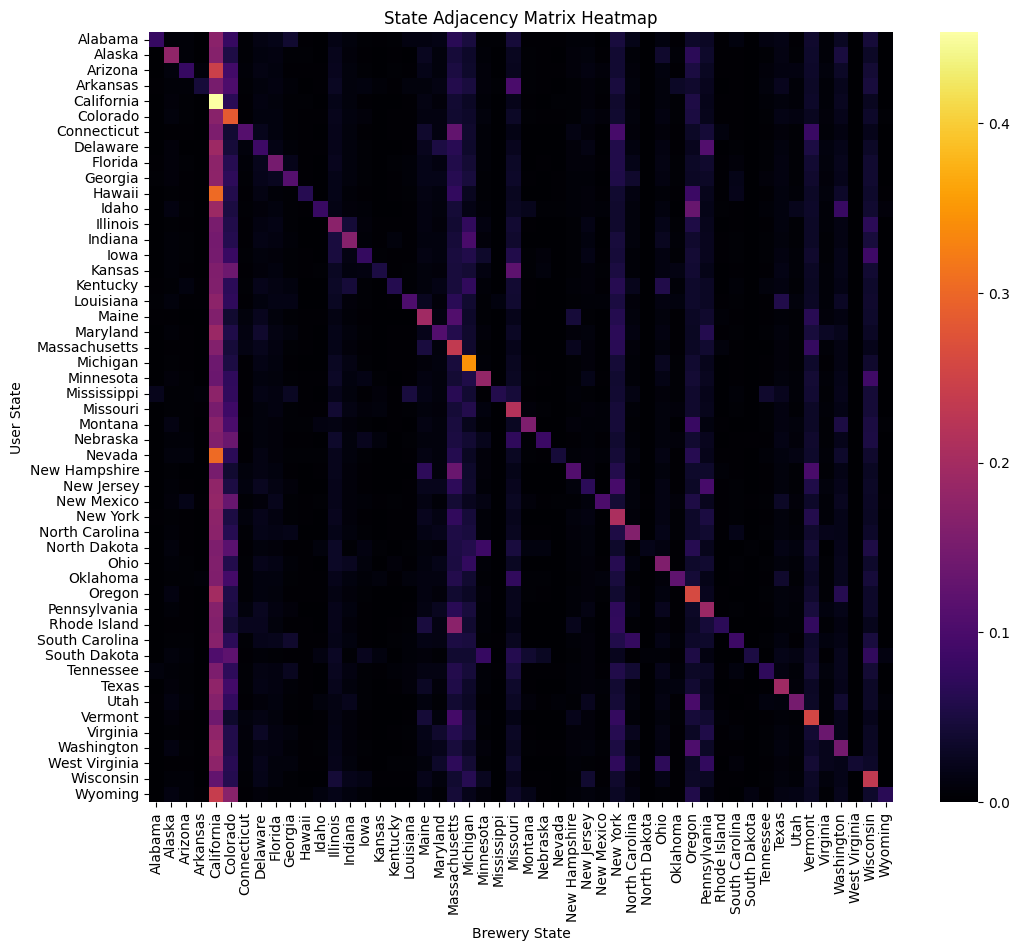

In [7]:
import seaborn as sns

from src.data.plots import plot_state_matrix_as_heatmap
from src.data.state_counts import get_state_adjacency_matrix

state_adj_matrix = get_state_adjacency_matrix(usa_ratings_merged, states, as_ratio=True, drop_world=True)
plot_state_matrix_as_heatmap(state_adj_matrix, title='State Adjacency Matrix Heatmap', xlabel='Brewery State', ylabel='User State')

It seems this somewhat confirms our previous visualization most states review a lot of their own beers. Additionaly it seems some vertical lines appear for a small subset of brewery states which would suggest that most national reviews come from this subset of states, with a majority of national reviews being californian beers.

Interestingly there appears to be a corrolation between the local review ratio of a state and how likely they are to appear significantly in reviews by other states other states. To make this pattern a bit clearer let's order the matrix by local review ratio. However these are probably just states that produce a lot of different beers.

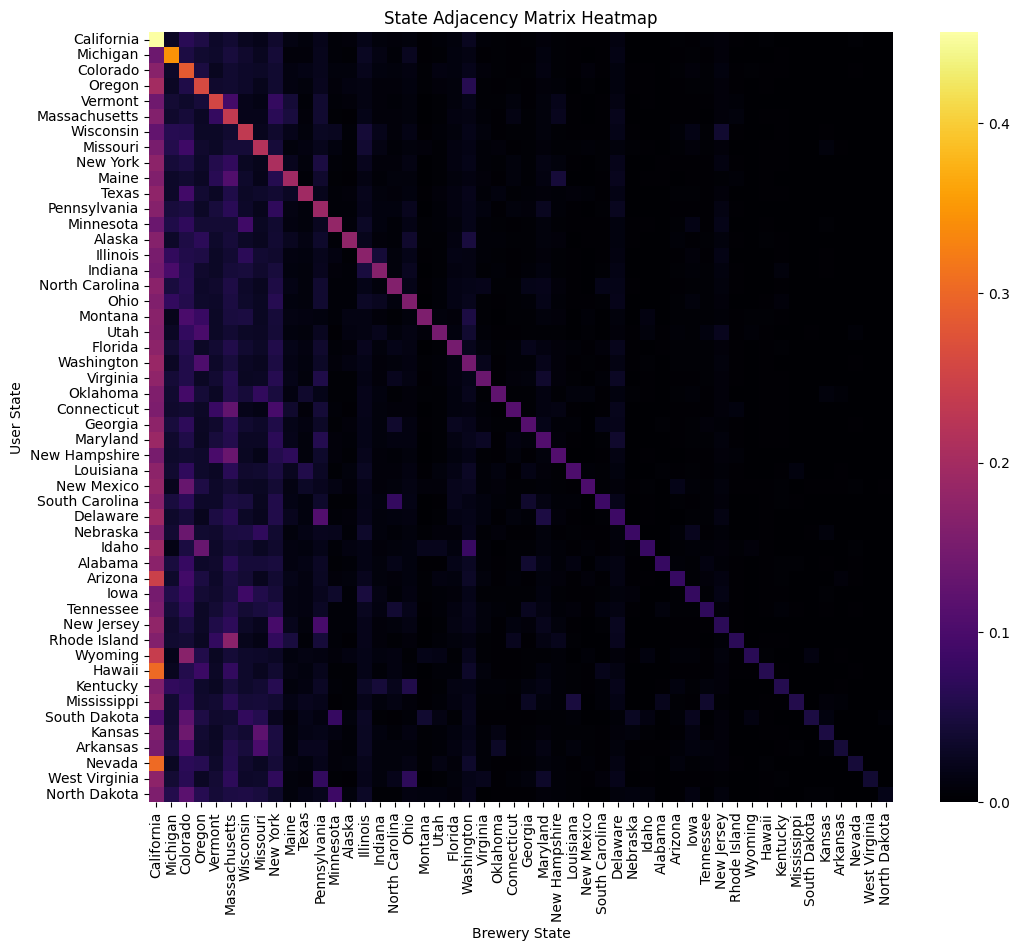

In [8]:
from src.data.state_counts import sort_matrix_by_diagonal


sorted_ajd_matrix = sort_matrix_by_diagonal(state_adj_matrix)
plot_state_matrix_as_heatmap(sorted_ajd_matrix, title='State Adjacency Matrix Heatmap', xlabel='Brewery State', ylabel='User State')

In [9]:
from matplotlib.animation import FuncAnimation

from src.data.plots import create_yearly_heatmap_gif

# create_yearly_heatmap_gif(ba_usa_ratings_merged, states, "heatmap_yearly.gif")

### Country wise trend of beer

We look at how local, national and foreign reviews evolve over time by looking at the country wise ratios (as in we sum local, national and foreign reviews across all states).

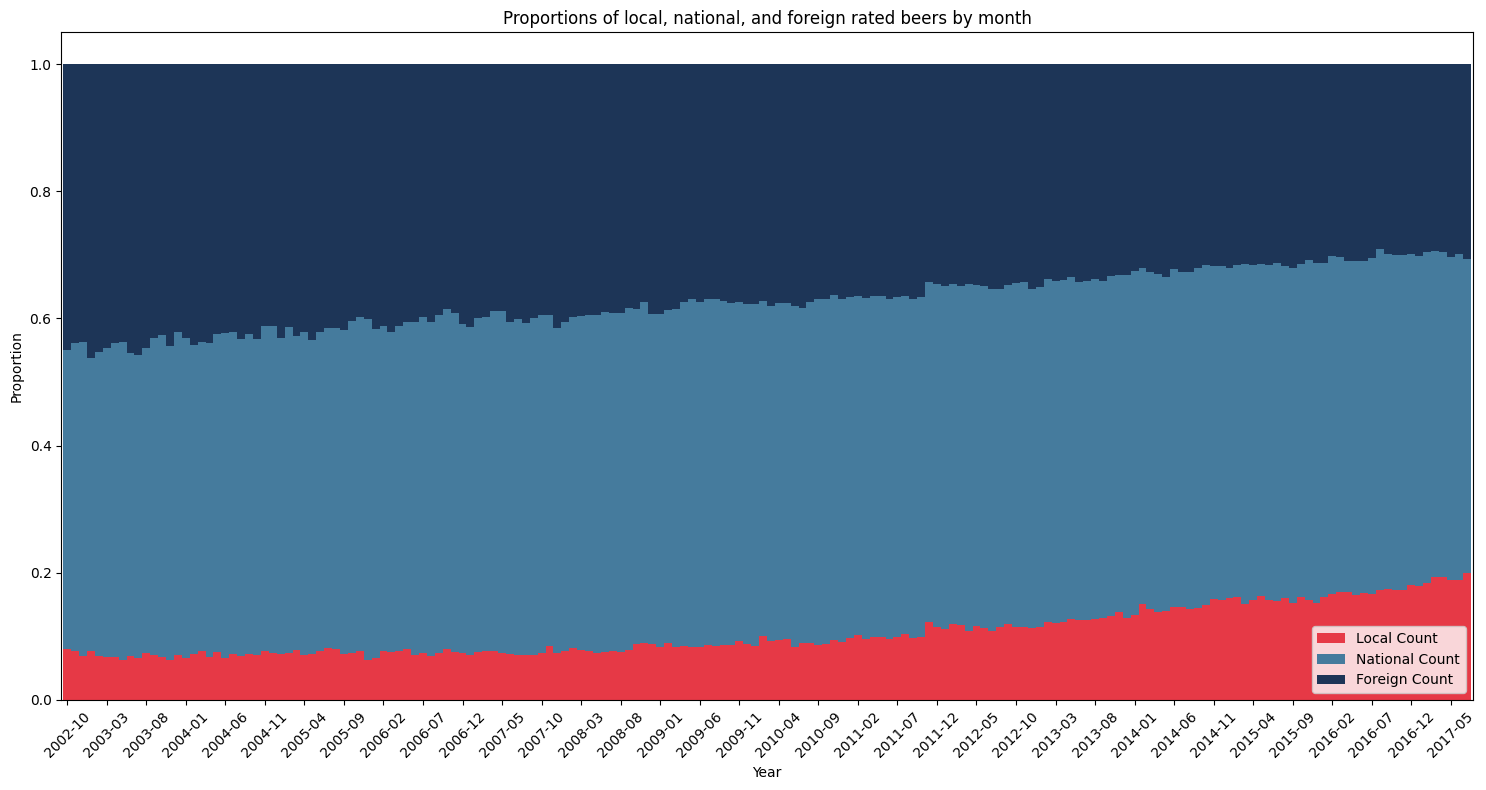

In [10]:
from src.data.state_counts import get_monthly_counts_usa
from src.data.plots import plot_monthly_country_counts

start_month = datetime.strptime("2002-10", "%Y-%m").date()
end_month = datetime.strptime("2017-07", "%Y-%m").date()
us_monthly_ratios = get_monthly_counts_usa(
    usa_ratings_merged, states, start_month=start_month, end_month=end_month, cumulative=False, as_ratio=True
)

ax = plot_monthly_country_counts(
    us_monthly_ratios, 
    title='Proportions of local, national, and foreign rated beers by month',
    xlabel='Year',
    ylabel='Proportion',
    date_steps=5, 
    colors=us_colors
)

# Breweries

In [11]:
new_breweries, time_span = breweries_first_date(usa_ratings, breweries)

US_State_index = pd.unique(usa_ratings['state'])
brew_world = monthly_new_breweries(new_breweries, time_span)
brew_us = monthly_new_breweries(new_breweries[new_breweries['location'].isin(US_State_index)], time_span)

c:\Users\41763\Desktop\ADA\Project\ada-2024-project-fandemondada\src\data\breweries.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brew_df['year_month'] = pd.to_datetime(brew_df['first_rev']).dt.to_period('M')


In [12]:
cum_brew = brew_world.merge(brew_us, left_index=True, right_index=True, suffixes=('_World', '_US'))
cum_brew['frac'] = cum_brew['cumulative_US'] / cum_brew['cumulative_World']

Text(0, 0.5, 'Number of breweries')

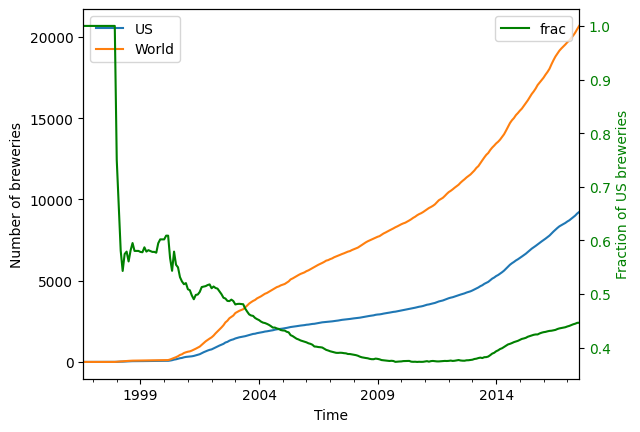

In [13]:
fig, ax = plt.subplots(1, 1)
cum_brew.plot(y= ['cumulative_US', 'cumulative_World'], ax=ax, label=['US', 'World'])
ax.set_xlabel('Time')

ax.legend()

ax2 = ax.twinx()  # instantiate a second Axes that shares the same x-axis
cum_brew.plot(y= ['frac'], ax=ax2, color='g')
ax2.set_ylabel('Fraction of US breweries', color='g')  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor='g')

ax.set_ylabel("Number of breweries")

## Per state new breweries

In [14]:
brewery_state_dic = {}

# the list of state names is the list of unique values of the state of origin of the users, as we only have reviews from users in the US
for state in pd.unique(usa_ratings['state']):
    # New_breweries has already the first review date
    brewery_state_dic[state] = new_breweries[new_breweries['state'] == state]


new_brew_state_dic = {key: {} for key in brewery_state_dic.keys()}
for key in brewery_state_dic.keys():
    new_brew_state_dic[key] = monthly_new_breweries(brewery_state_dic[key], time_span)


In [15]:
new_brew_state_dic['California']

count  cumulative
year_month                   
1996-08       0.0         0.0
1996-09       0.0         0.0
1996-10       0.0         0.0
1996-11       0.0         0.0
1996-12       0.0         0.0
...           ...         ...
2017-03       4.0      1164.0
2017-04      14.0      1178.0
2017-05      12.0      1190.0
2017-06      18.0      1208.0
2017-07       6.0      1214.0

[252 rows x 2 columns]

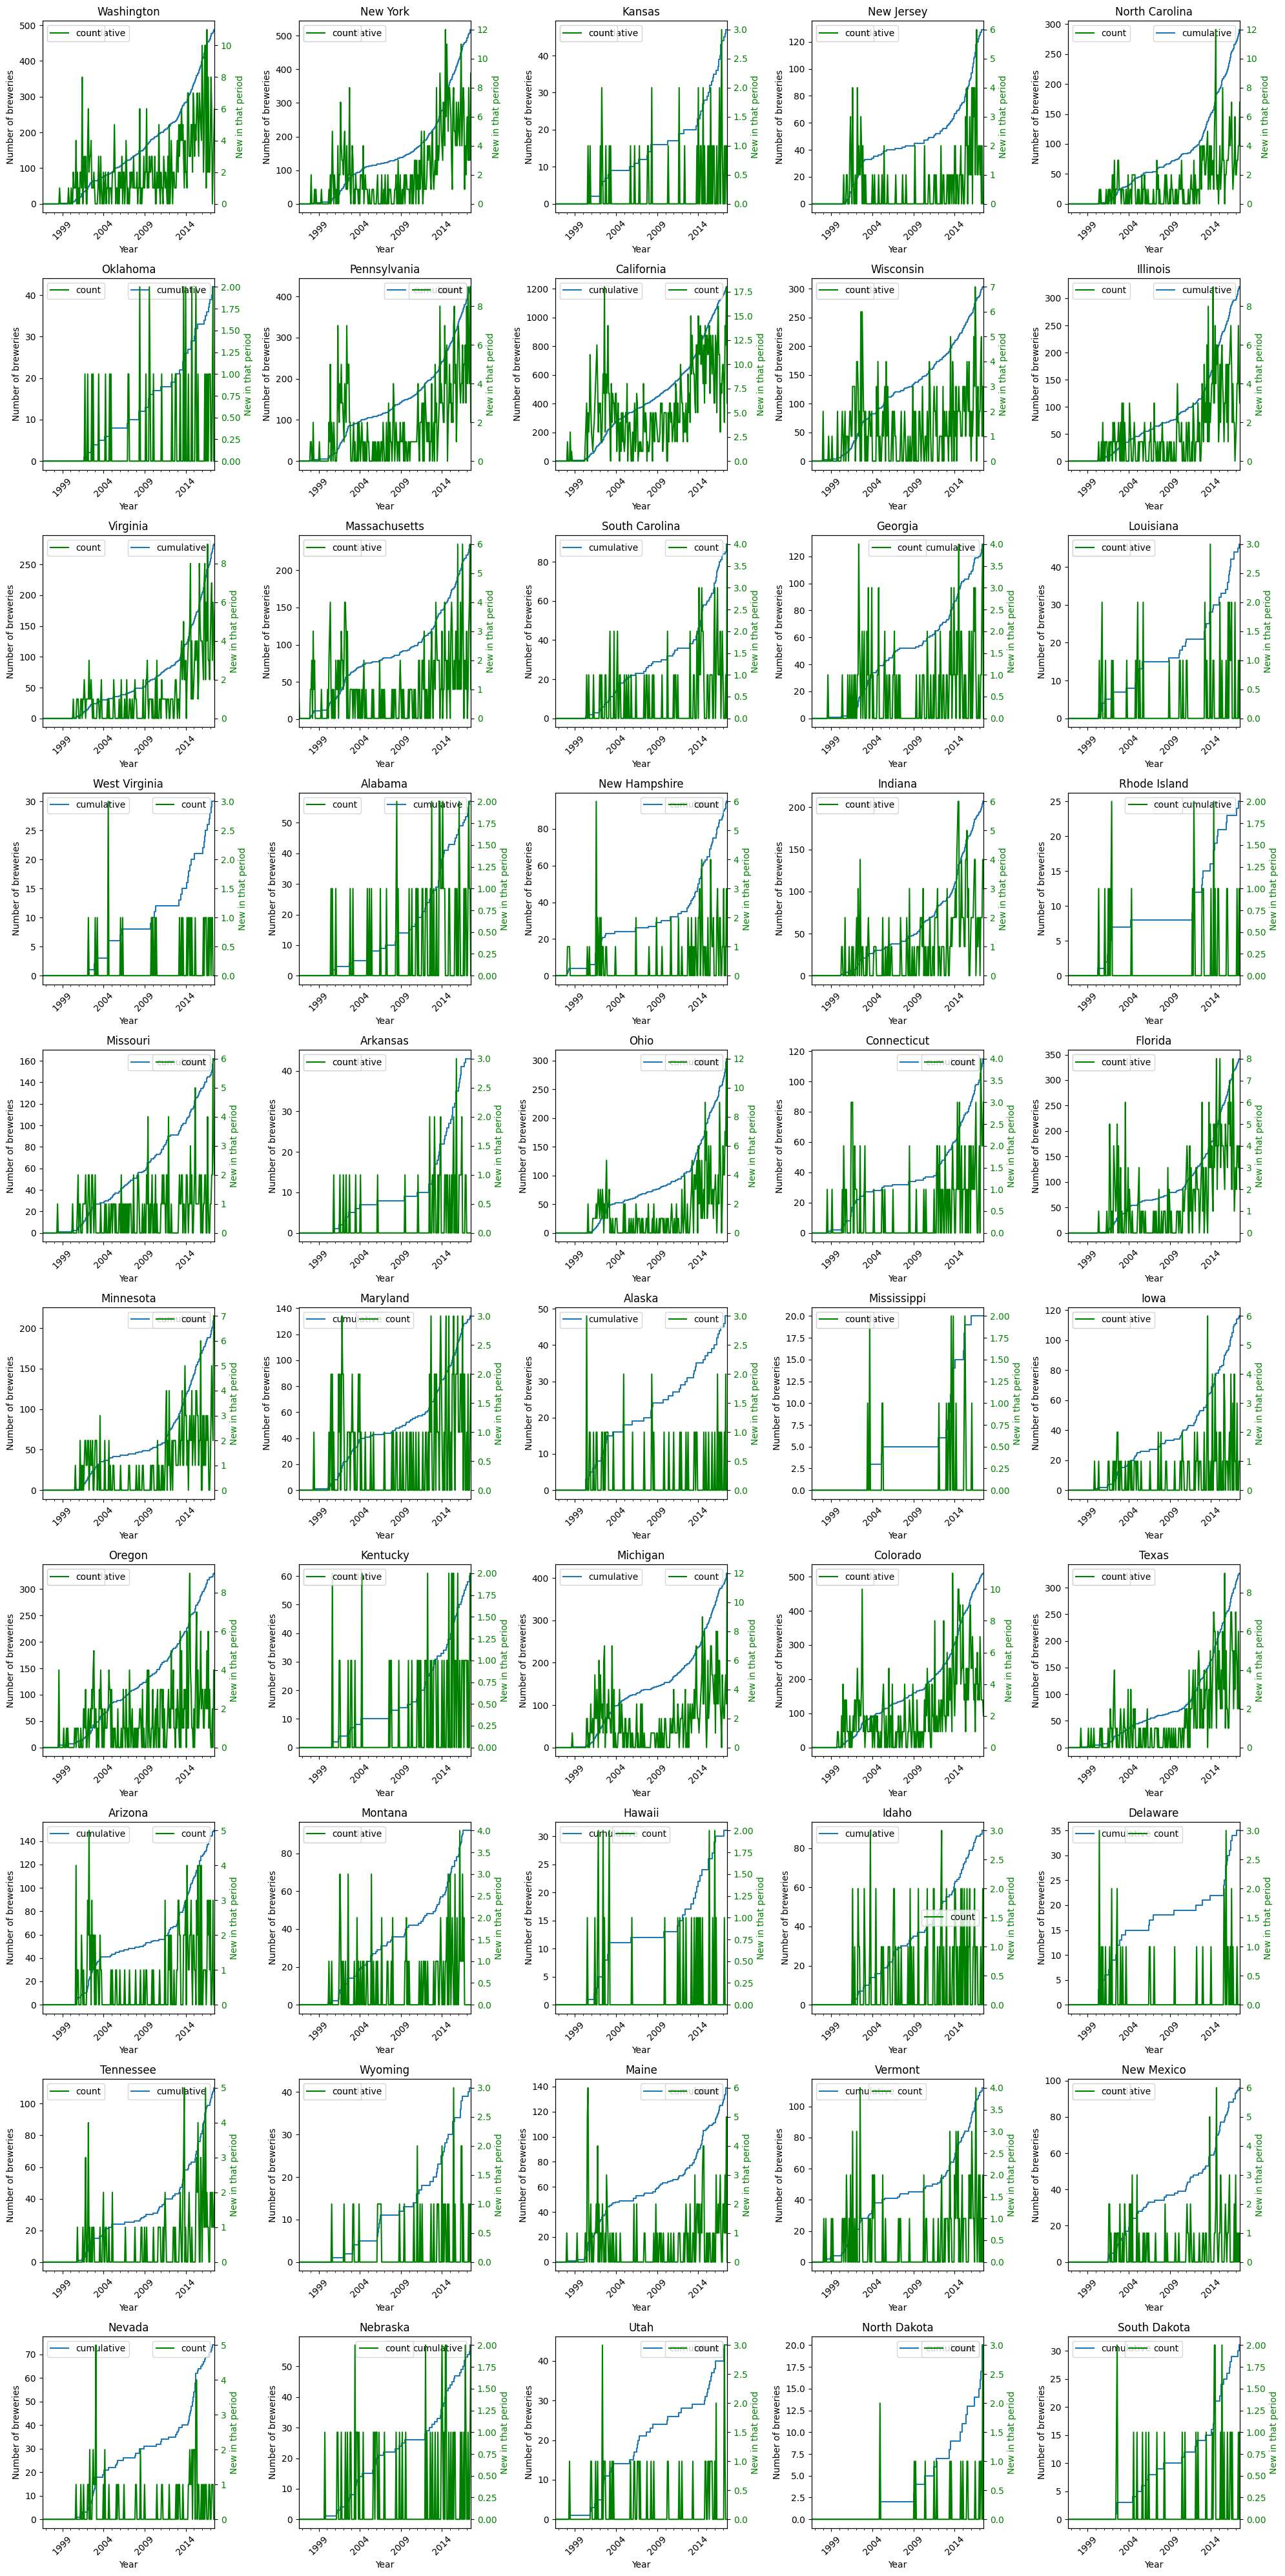

In [16]:
import math
num_states = len(new_brew_state_dic)
cols = 5
rows = math.ceil(num_states / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axs = axs.flatten()

for i, (state, df) in enumerate(new_brew_state_dic.items()):
    #monthly_avg = df.groupby('year_month')['distance'].mean()
    df.plot(drawstyle="steps", y= ['cumulative'], ax=axs[i], linestyle='-')
    axs[i].set_title(f"{state}")
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Number of breweries")
    axs[i].tick_params(axis='x', rotation=45)

    ax2 = axs[i].twinx()  # instantiate a second Axes that shares the same x-axis
    df.plot(y= ['count'], ax=ax2, color='g')
    ax2.set_ylabel('New in that period', color='g')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='g')


plt.tight_layout()
plt.show()

# Distances

In [17]:
# to do only the first time to generate the file with all distances (takes 10min on my laptop)
# compute_distances(user_state_dic)

# to load the distances into a dict
dict_test = load_distances("data/clean/")

In [16]:
# print(dict_test.keys())
# print(user_state_dic.keys())
# user_state_dic['California'].head()

In [18]:
import ast
#use ast to interpret the weird string as a tuple
new_data = [(*ast.literal_eval(k), v['distance']) for k, v in dict_test.items()]
df = pd.DataFrame(new_data, columns=["place1", "place2", "distance"])
distance_table = df.pivot(index='place1', columns='place2', values='distance')
distance_table = distance_table.combine_first(distance_table.T)
#fill not needed distances with 0
distance_table = distance_table.fillna(0)
#print(distance_table)


In [19]:
user_state_dic = {}

for state in pd.unique(usa_ratings['state']):
    user_state_dic[state] = usa_ratings[usa_ratings['state'] == state]

for key in user_state_dic.keys():
    user_state_dic[key] = user_state_dic[key].merge(breweries[['brewery_id', 'state']], on='brewery_id', how='left')
    user_state_dic[key] = user_state_dic[key].rename(columns={'state_x': 'user_state', 'state_y': 'brewery_state'})



In [20]:

#separate in months
usa_ratings['year_month'] = pd.to_datetime(usa_ratings['date']).dt.to_period('M')

for key in user_state_dic.keys():
    user_state_dic[key]['year_month'] = pd.to_datetime(user_state_dic[key]['date']).dt.to_period('M')

In [21]:
#add distance column to each review
for state in user_state_dic.keys():
    user_state_dic[state]['distance'] = user_state_dic[state].apply(lambda row: distance_table.loc[row['user_state'], row['brewery_state']], axis=1)

KeyError: 'Guinea-Bissau'

In [34]:
user_state_dic['California']

Unnamed: 0                 beer_name  beer_id  \
0               11                  Legbiter    19827   
1              146        St. Patrick's Best    20842   
2              187       Caffrey's Irish Ale      825   
3              198       Caffrey's Irish Ale      825   
4              209       Caffrey's Irish Ale      825   
...            ...                       ...      ...   
658195     8393011  Witch's Hair Pumpkin Ale    64097   
658196     8393012  Witch's Hair Pumpkin Ale    64097   
658197     8393013  Witch's Hair Pumpkin Ale    64097   
658198     8393014  Witch's Hair Pumpkin Ale    64097   
658199     8393015  Witch's Hair Pumpkin Ale    64097   

                                brewery_name  brewery_id             style  \
0       Strangford Lough Brewing Company Ltd       10093  English Pale Ale   
1       Strangford Lough Brewing Company Ltd       10093    English Bitter   
2                 Thomas Caffrey Brewing Co.         297     Irish Red Ale   
3                 Thomas Caffrey Brewing Co.         297     Irish Red Ale   
4                 Thomas Caffrey Brewing Co.         297     Irish Red Ale   
...                                      ...         ...               ...   
658195                Twisted Manzanita Ales       23640       Pumpkin Ale   
658196                Twisted Manzanita Ales       23640       Pumpkin Ale   
658197                Twisted Manzanita Ales       23640       Pumpkin Ale   
658198                Twisted Manzanita Ales       23640       Pumpkin Ale   
658199                Twisted Manzanita Ales       23640       Pumpkin Ale   

        abv        date        user_name                 user_id  ...  \
0       4.8  2013-04-25  GraduatedCashew  graduatedcashew.730089  ...   
1       4.2  2010-03-09      Mosstrooper      mosstrooper.235403  ...   
2       3.8  2003-08-04       beerguy101          beerguy101.137  ...   
3       3.8  2002-09-24             zerk                zerk.422  ...   
4       3.8  2001-04-03             Todd                  todd.2  ...   
...     ...         ...              ...                     ...  ...   
658195  9.5  2011-11-03         HalfFull         halffull.196628  ...   
658196  9.5  2011-10-31        HopHead84        hophead84.109437  ...   
658197  9.5  2011-10-14      badboyrsl84      badboyrsl84.428065  ...   
658198  9.5  2011-01-24       Alexmatt86       alexmatt86.313751  ...   
658199  9.5  2010-12-04    womencantsail    womencantsail.222552  ...   

        appearance_nan  aroma_nan  palate_nan  taste_nan  overall_nan  \
0                    1          1           1          1            1   
1                    0          0           0          0            0   
2                    0          0           0          0            0   
3                    0          0           0          0            0   
4                    0          0           0          0            0   
...                ...        ...         ...        ...          ...   
658195               0          0           0          0            0   
658196               0          0           0          0            0   
658197               0          0           0          0            0   
658198               0          0           0          0            0   
658199               0          0           0          0            0   

                         location  user_state  year_month     brewery_state  \
0       United States, California  California     2013-04  Northern Ireland   
1       United States, California  California     2010-03  Northern Ireland   
2       United States, California  California     2003-08  Northern Ireland   
3       United States, California  California     2002-09  Northern Ireland   
4       United States, California  California     2001-04  Northern Ireland   
...                           ...         ...         ...               ...   
658195  United States, California  California     2011-11        California   


In [37]:
new_brew_state_dic['California']

count  cumulative
year_month                   
1996-08       0.0         0.0
1996-09       0.0         0.0
1996-10       0.0         0.0
1996-11       0.0         0.0
1996-12       0.0         0.0
...           ...         ...
2017-03       3.0       762.0
2017-04      11.0       773.0
2017-05       9.0       782.0
2017-06      16.0       798.0
2017-07       3.0       801.0

[252 rows x 2 columns]

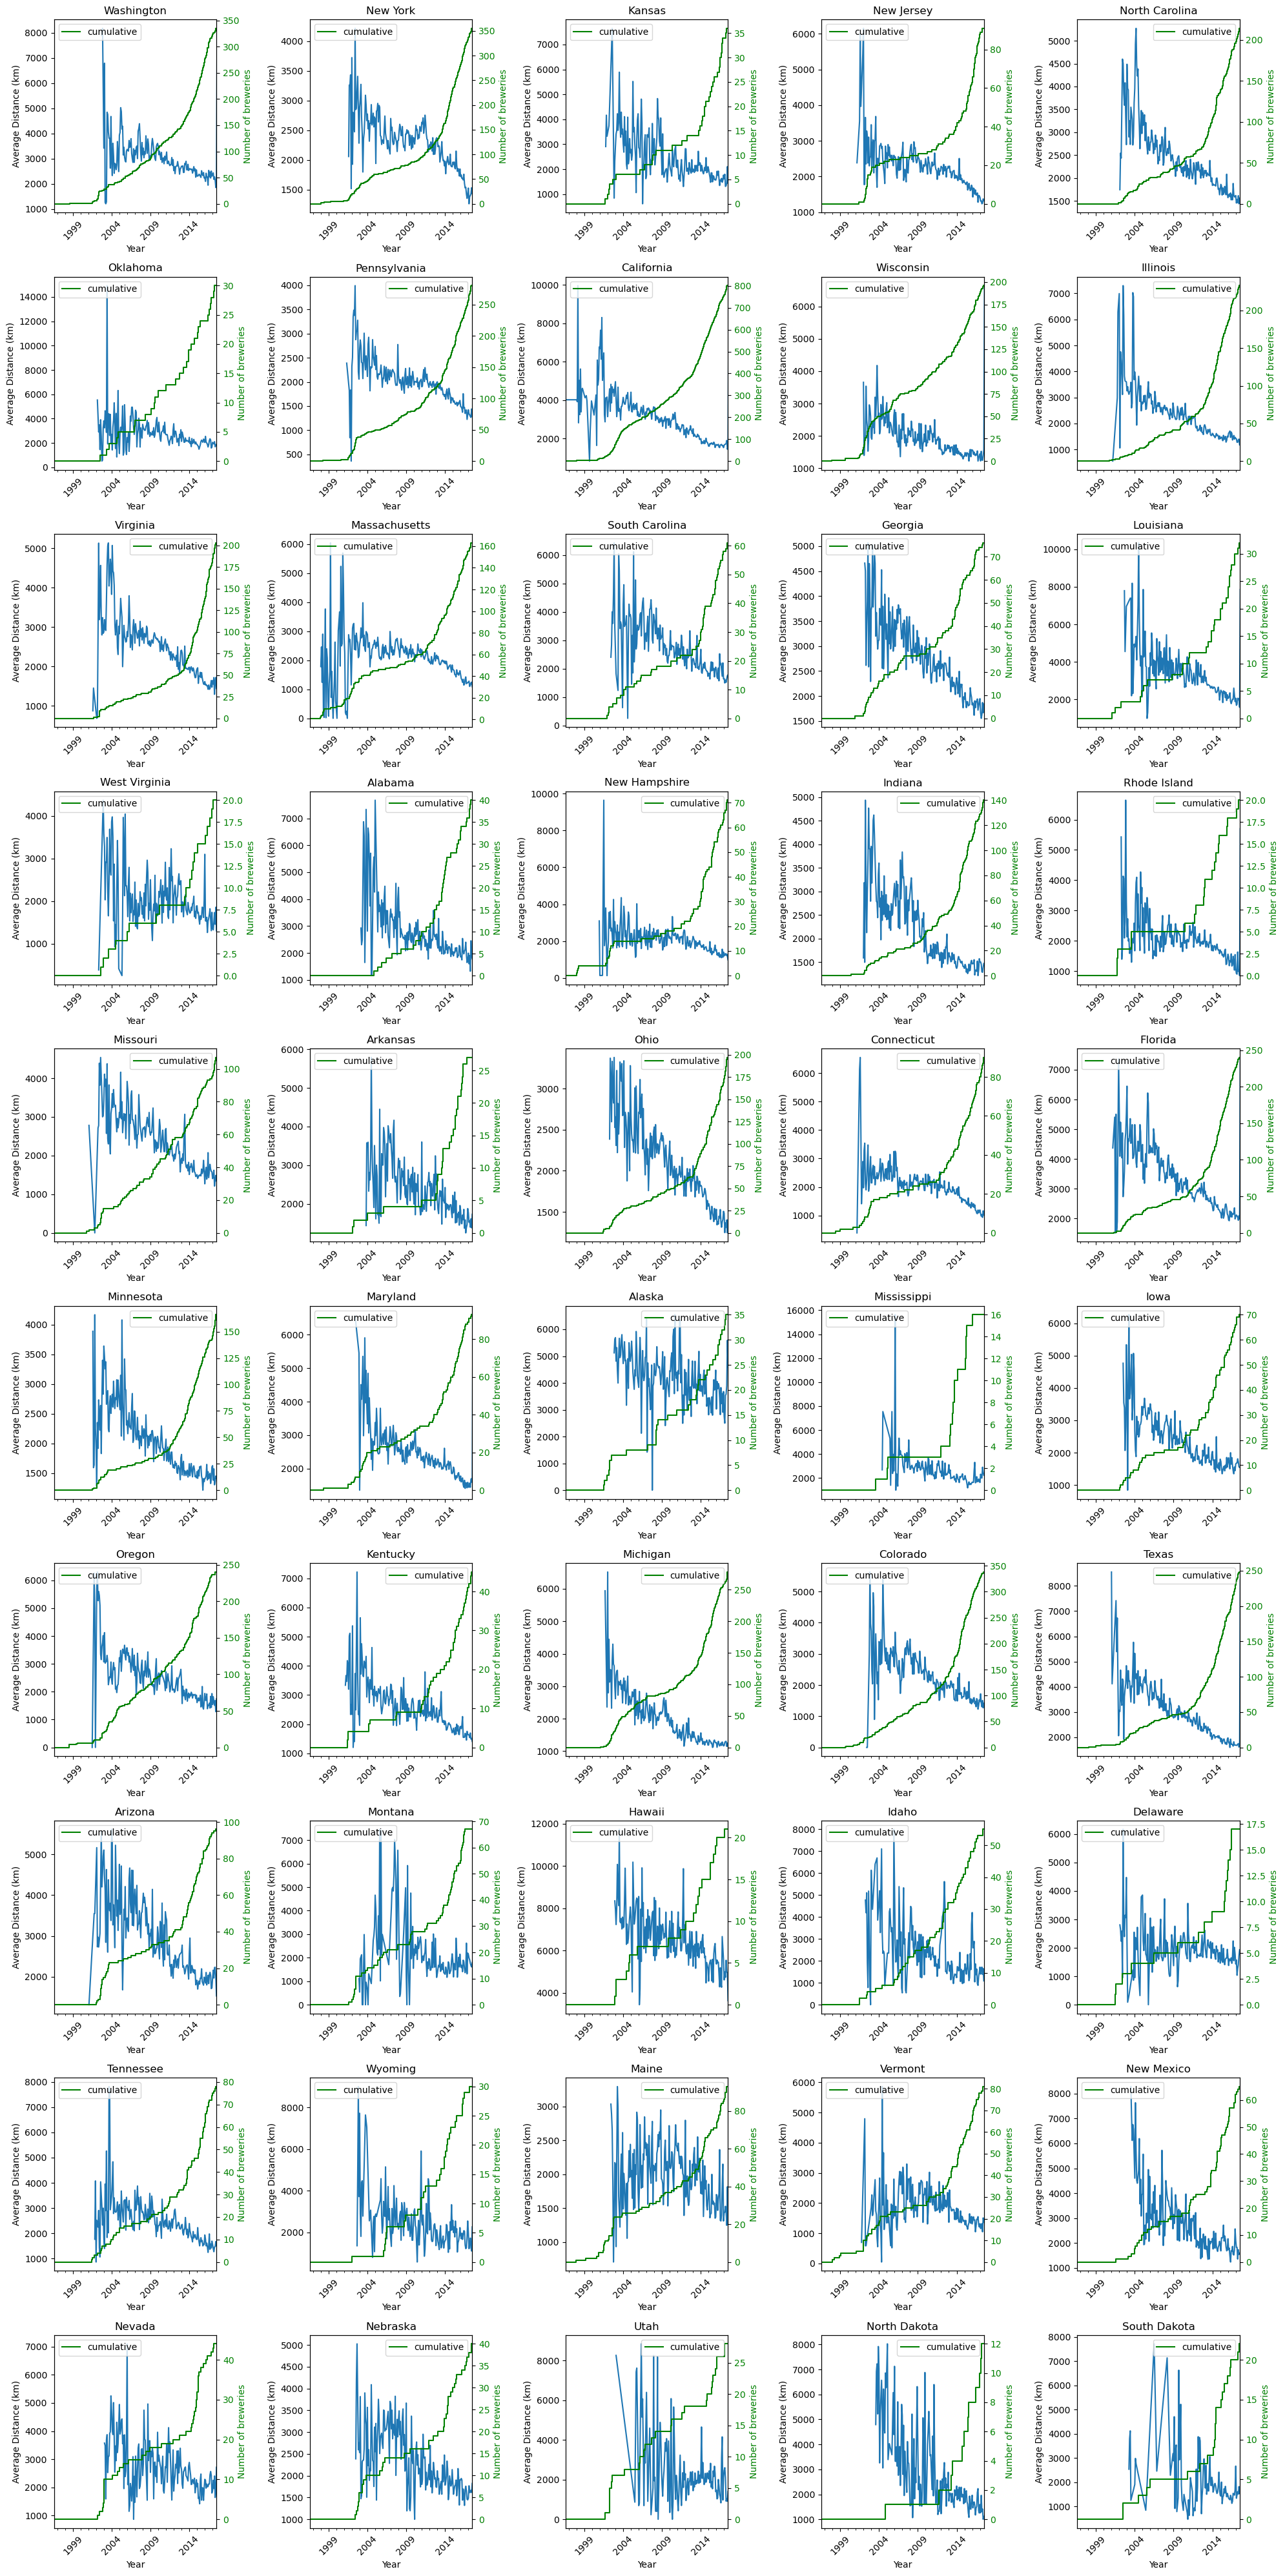

In [38]:
import math
num_states = len(user_state_dic)
cols = 5
rows = math.ceil(num_states / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axs = axs.flatten()

for i, (state, df) in enumerate(user_state_dic.items()):
    monthly_avg = df.groupby('year_month')['distance'].mean()
    monthly_avg.plot(ax=axs[i], linestyle='-')
    axs[i].set_title(f"{state}")
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Average Distance (km)")
    axs[i].tick_params(axis='x', rotation=45)

    ax2 = axs[i].twinx()
    # new brweries in that state
    new_brew_state_dic[state].plot(drawstyle="steps", y=['cumulative'], ax=ax2, linestyle='-', color='g')
    ax2.set_ylabel('Number of breweries', color='g')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='g')


plt.tight_layout()
plt.show()


C:\Users\felix\AppData\Local\Temp\ipykernel_15248\830292725.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


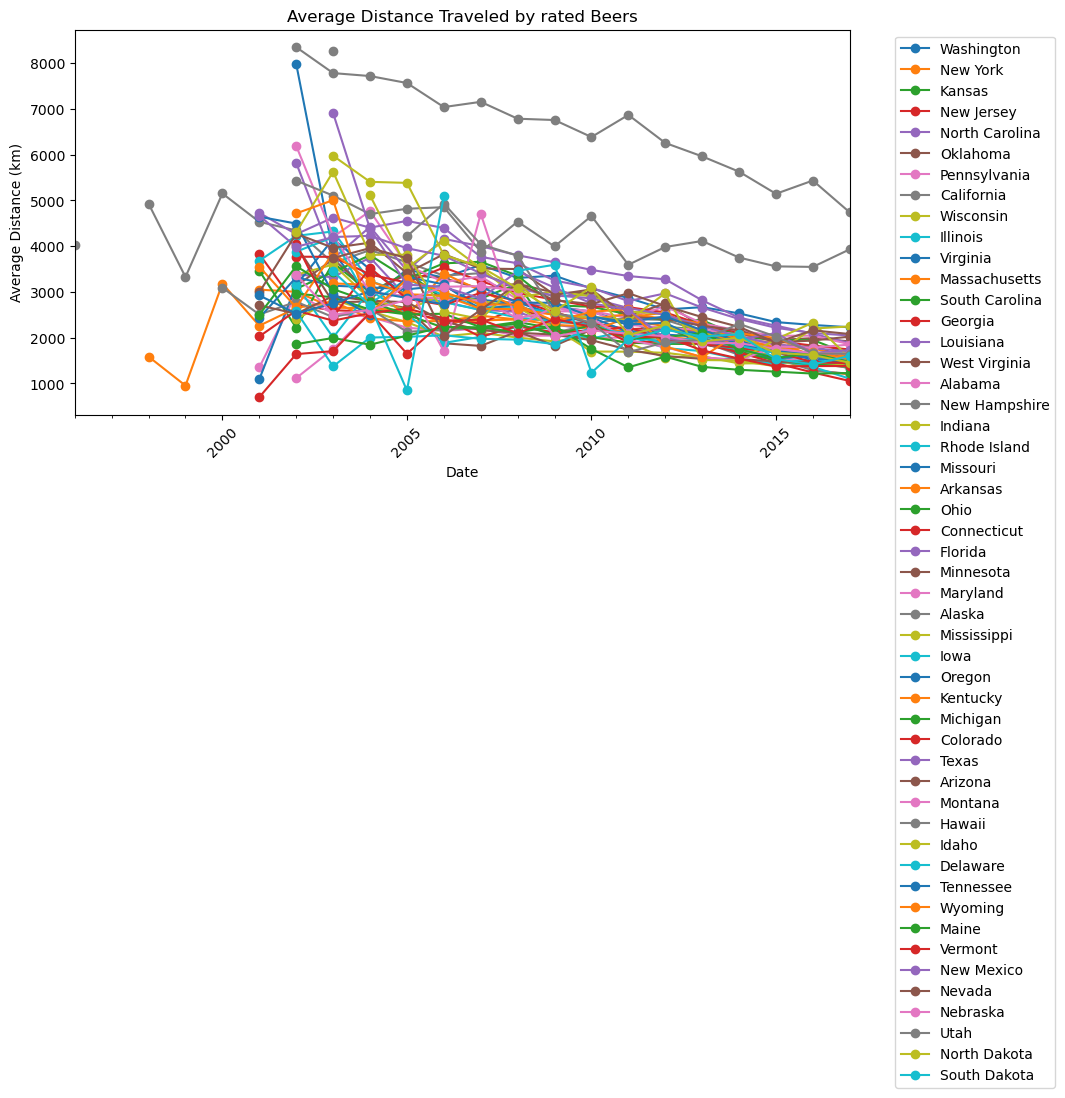

In [13]:
plt.figure(figsize=(10, 5))

for state, df in user_state_dic.items():
    df['year_month_dt'] = pd.to_datetime(df['year_month'].astype(str), format='%Y-%m')
    
    #group by year
    monthly_avg_1y = df.groupby(pd.Grouper(key='year_month_dt', freq='1YE'))['distance'].mean()
    monthly_avg_1y.plot(marker='o', label=state)

plt.title("Average Distance Traveled by rated Beers")
plt.xlabel("Date")
plt.ylabel("Average Distance (km)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [17]:
#import libraries
import pandas as pd
import plotly.express as px

# get all locations code
code = {'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'}

# source of the file "all.csv" with all the country codes: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
countries = pd.read_csv("./all.csv")
dict_distances = countries.set_index('name')['alpha-3'].to_dict()
code.update(dict_distances)

#import data
data = state_provenance_df
data = data.reset_index()

data['Code'] = data['index'].map(code)

breweries_test = breweries.groupby("location").count()
breweries_test = breweries_test.reset_index()
breweries_test["Code"] = breweries_test['location'].map(code)

# remove fig2 and change scope to have only US statewise map
fig = px.choropleth(breweries_test,
                    locations='Code',
                    color='nbr_beers',
                    color_continuous_scale='spectral_r',
                    hover_name='location',
                    locationmode='USA-states',     
                    labels={'Local count':'count %'},
                    scope='world')

fig2 = px.choropleth(breweries_test,
                    locations='Code',
                    color='nbr_beers',
                    color_continuous_scale='spectral_r',
                    hover_name='location',
                    locationmode='ISO-3',       
                    labels={'Local count':'count %'},
                    scope='world')
 
fig.add_trace(fig2.data[0])

fig.show()